# **Crypto forecasting tutorial**

# G-Research Crypto forecasting competition

In the [G-Research Crypto forecasting competition](link), participants have the challenge to predict  price returns across a bundle of major cryptocurrencies. To facilitate your participation, we have created this tutorial notebook covering some relevant concepts for the crypto forecasting challenge.

The notebook presents an introduction to crypto forecasting, describing the structure and elements of the dataset, some relevant statistical properties, as well as building a couple of ML baseline models and providing an example code submission.



## The Cryptocurrency Market

First, a quick introduction to the crypto world. Cryptocurrencies have become an extremely popular and volatile market, delivering massive returns (as well as losses) to investors. Thousands of cryptocurrencies have been created with a few major ones that many of you will have heard of including Bitcoin (BTC), Ether (ETH) or Dogecoin (DOGE).

Cryptocurrencies are traded extensively across crypto-exchanges, with an average volume of $41 billion traded daily over the last year, according to CryptoCompare (as of 25th July 2021). 

Changes in prices between different cryptocurrencies are highly interconnected. For example, Bitcoin has historically been a major driver of price changes across cryptocurrencies but other coins also impact the market.  



## Forecasting returns

A fundamental task in financial modeling is predicting how prices will behave in the near future. Using the time-series of historical prices as training data, we want to predict if prices will go up or down, and by how much, namely the asset *returns*.

In this competition, Kagglers are challenged to build machine learning models to predict the returns of 14 popular cryptocurrencies, in the time scale of minutes to hours. You will have access to millions of rows of minute-by-minute cryptocurrency trading data, with which you'll design your forecasting models for all 14 assets simultaneously. Your predictions will be evaluated by how much they correlate with real market data collected during the three-month evaluation period after the competition has closed. 

Cryptocurrency returns prediction remains an open and extremely challenging forecasting task. This is a fascinating problem domain for the ML community given the extreme volatility of the assets, the non-stationary nature of the data, the market and meme manipulation, the correlation between assets and the very fast changing market conditions. We hope you find it as fascinating as we do! 


# Dataset description

Now, let's dive into the data! We start by loading the competition's dataset and inspecting its basic properties. 

## Load the training set

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
import seaborn as sns
import matplotlib.pyplot as plt
from plotly import tools
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)
import plotly.graph_objs as go
import gc
import sys
from keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn import preprocessing
from sklearn.metrics import mean_squared_error, mean_absolute_error, explained_variance_score, r2_score 
ep = sys.float_info.epsilon

In [2]:
data_folder = "input/"

In [2]:
crypto_df = pd.read_csv('train.csv')

In [4]:
crypto_df.head(10)

,timestamp,Asset_ID,Count,Open,High,Low,Close,Volume,VWAP,Target
0,1514764860,2,40.0,2376.580000,2399.5000,2357.1400,2374.590000,19.233005,2373.116392,-0.004218
1,1514764860,0,5.0,8.530000,8.5300,8.5300,8.530000,78.380000,8.530000,-0.014399
2,1514764860,1,229.0,13835.194000,14013.8000,13666.1100,13850.176000,31.550062,13827.062093,-0.014643
3,1514764860,5,32.0,7.659600,7.6596,7.6567,7.657600,6626.713370,7.657713,-0.013922
4,1514764860,7,5.0,25.920000,25.9200,25.8740,25.877000,121.087310,25.891363,-0.008264
5,1514764860,6,173.0,738.302500,746.0000,732.5100,738.507500,335.987856,738.839291,-0.004809
6,1514764860,9,167.0,225.330000,227.7800,222.9800,225.206667,411.896642,225.197944,-0.009791
7,1514764860,11,7.0,329.090000,329.8800,329.0900,329.460000,6.635710,329.454118,NaN
8,1514764920,2,53.0,2374.553333,2400.9000,2354.2000,2372.286667,24.050259,2371.434498,-0.004079
9,1514764920,0,7.0,8.530000,8.5300,8.5145,8.514500,71.390000,8.520215,-0.015875


In [5]:
crypto_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24236806 entries, 0 to 24236805
Data columns (total 10 columns):
 #   Column     Dtype  
---  ------     -----  
 0   timestamp  int64  
 1   Asset_ID   int64  
 2   Count      float64
 3   Open       float64
 4   High       float64
 5   Low        float64
 6   Close      float64
 7   Volume     float64
 8   VWAP       float64
 9   Target     float64
dtypes: float64(8), int64(2)
memory usage: 1.8 GB


In [5]:
crypto_df.max()

timestamp    1.632182e+09
Asset_ID     1.300000e+01
Count        1.650160e+05
Open         6.480594e+04
High         6.490000e+04
Low          6.467053e+04
Close        6.480854e+04
Volume       7.597554e+08
VWAP                  inf
Target       9.641699e-01
dtype: float64

## Data features
We can see the different features included in the dataset. Specifically, the features included per asset are the following:
*   **timestamp**: All timestamps are returned as second Unix timestamps (the number of seconds elapsed since 1970-01-01 00:00:00.000 UTC). Timestamps in this dataset are multiple of 60, indicating minute-by-minute data.
*   **Asset_ID**: The asset ID corresponding to one of the crytocurrencies (e.g. `Asset_ID = 1` for Bitcoin). The mapping from `Asset_ID` to crypto asset is contained in `asset_details.csv`.
*   **Count**: Total number of trades in the time interval (last minute).
*   **Open**:	Opening price of the time interval (in USD).
*   **High**:	Highest price reached during time interval (in USD).
*   **Low**: Lowest price reached during time interval (in USD).
*   **Close**:	Closing price of the time interval (in USD).
*   **Volume**:	Quantity of asset bought or sold, displayed in base currency USD.
*   **VWAP**: The average price of the asset over the time interval, weighted by volume. VWAP is an aggregated form of trade data.
*   **Target**: Residual log-returns for the asset over a 15 minute horizon. 

The first two columns define the time and asset indexes for this data row. The 6 middle columns are feature columns with the trading data for this asset and minute in time. The last column is the prediction target, which we will get to later in more detail.

We also view the asset information, including the list of all assets, the `Asset_ID` to asset mapping, and the weight of each asset used to weigh their relative importance in the evaluation metric.

##### Assets 

In [3]:
asset_details = pd.read_csv('asset_details.csv')
asset_details

,Asset_ID,Weight,Asset_Name
0,2,2.397895,Bitcoin Cash
1,0,4.304065,Binance Coin
2,1,6.779922,Bitcoin
3,5,1.386294,EOS.IO
4,7,2.079442,Ethereum Classic
5,6,5.894403,Ethereum
6,9,2.397895,Litecoin
7,11,1.609438,Monero
8,13,1.791759,TRON
9,12,2.079442,Stellar


### Seperate Assets

In [4]:
asset_df_dict = {}

# split train data to 14 asset dataframe 
for asset_id in range(14):
    
    asset_df = crypto_df[crypto_df["Asset_ID"]==asset_id].reset_index(drop=True)
    #asset_df.index = asset_df.timestamp
    asset_df.index = asset_df.timestamp.astype('datetime64[s]')
    asset_df_dict[asset_id] = asset_df

In [5]:
for asset_id in asset_df_dict.keys():
    beg_asset = asset_df_dict[asset_id].index[0].astype('datetime64[s]')
    end_asset = asset_df_dict[asset_id].index[-1].astype('datetime64[s]')
    
    print(asset_details[asset_details["Asset_ID"] == asset_id]['Asset_Name'].iloc[0]
          ,' data goes from ', beg_asset, 'to ', end_asset,'\n')

AttributeError: 'Timestamp' object has no attribute 'astype'

In [ ]:
for asset_id in range(3):
    print(asset_details[asset_details["Asset_ID"] == asset_id]['Asset_Name'].iloc[0] , '\n')
    print((asset_df_dict[asset_id].index[1:]-asset_df_dict[asset_id].index[:-1]).value_counts().head())


In [ ]:
for asset_id in range(3):
    print(asset_details[asset_details["Asset_ID"] == asset_id]['Asset_Name'].iloc[0] , '\n')
    print(asset_df_dict[asset_id].isna().sum())

# visualization

##### plot close density for each asset

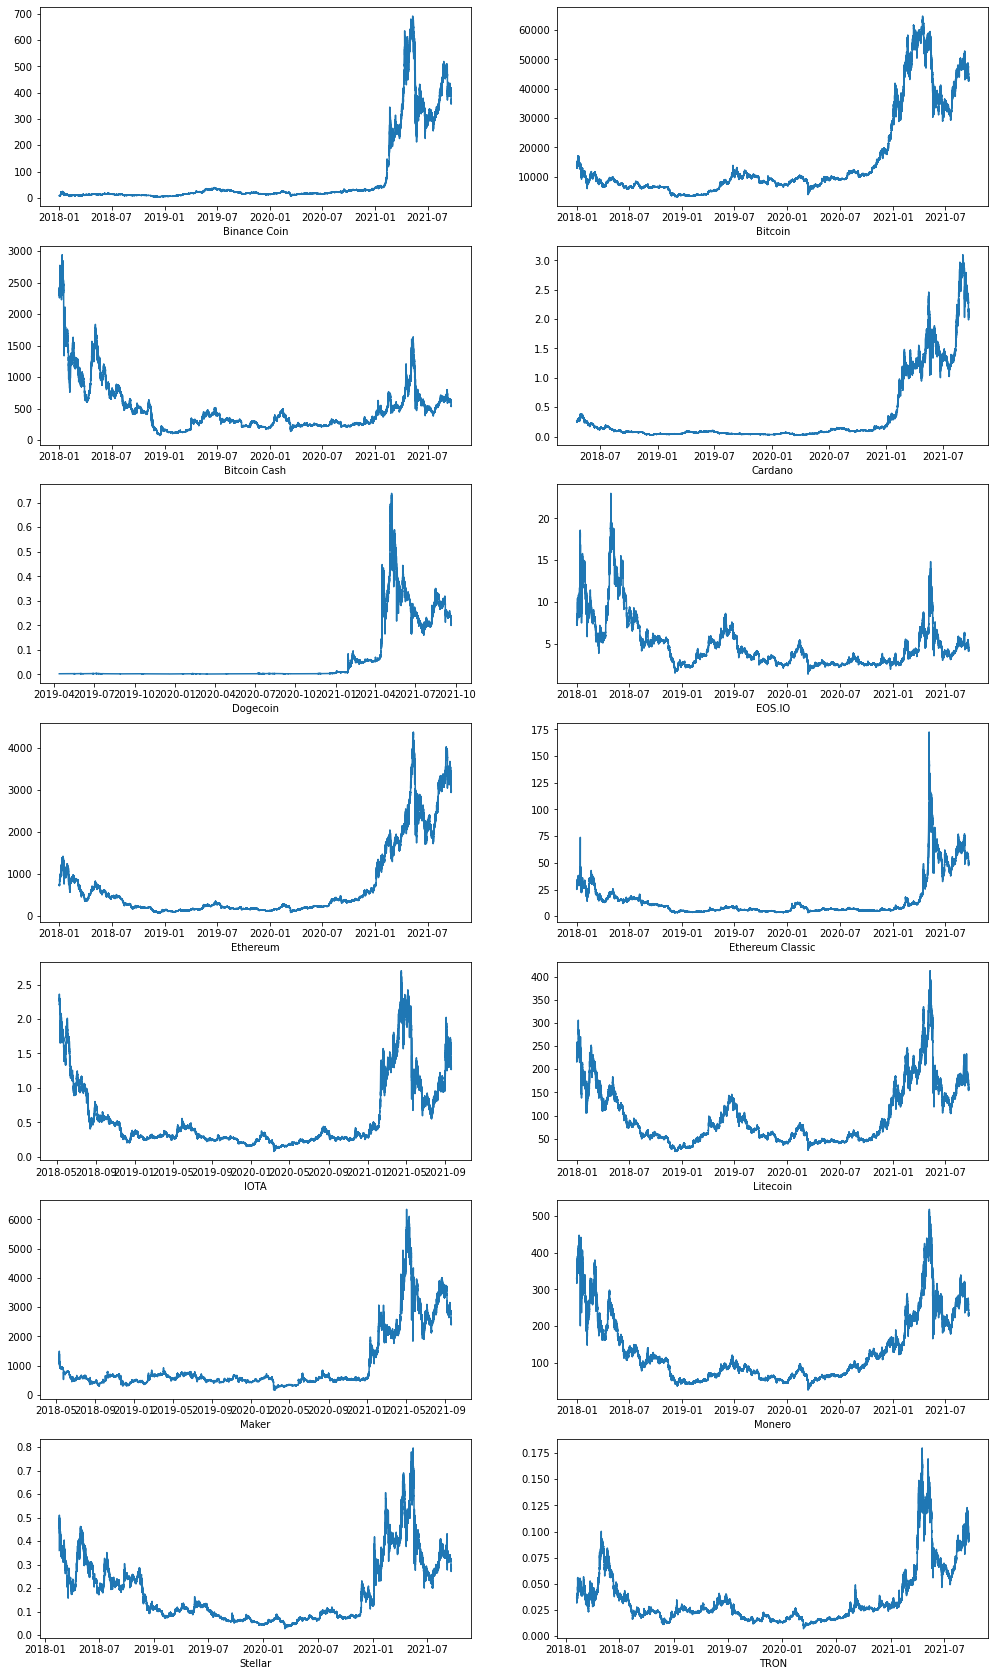

In [14]:
f,axes = plt.subplots(nrows=7,ncols=2,figsize =(17,30))
axc=[(i,j) for i in range(7) for j in range(2)]
for asset_id in asset_df_dict.keys():
    asset_name = asset_details[asset_details["Asset_ID"] == asset_id]['Asset_Name'].iloc[0]  
    axes[axc[asset_id][0],axc[asset_id][1]].plot(asset_df_dict[asset_id]['Close'])
    axes[axc[asset_id][0],axc[asset_id][1]].set(xlabel=asset_name)
    
plt.show()

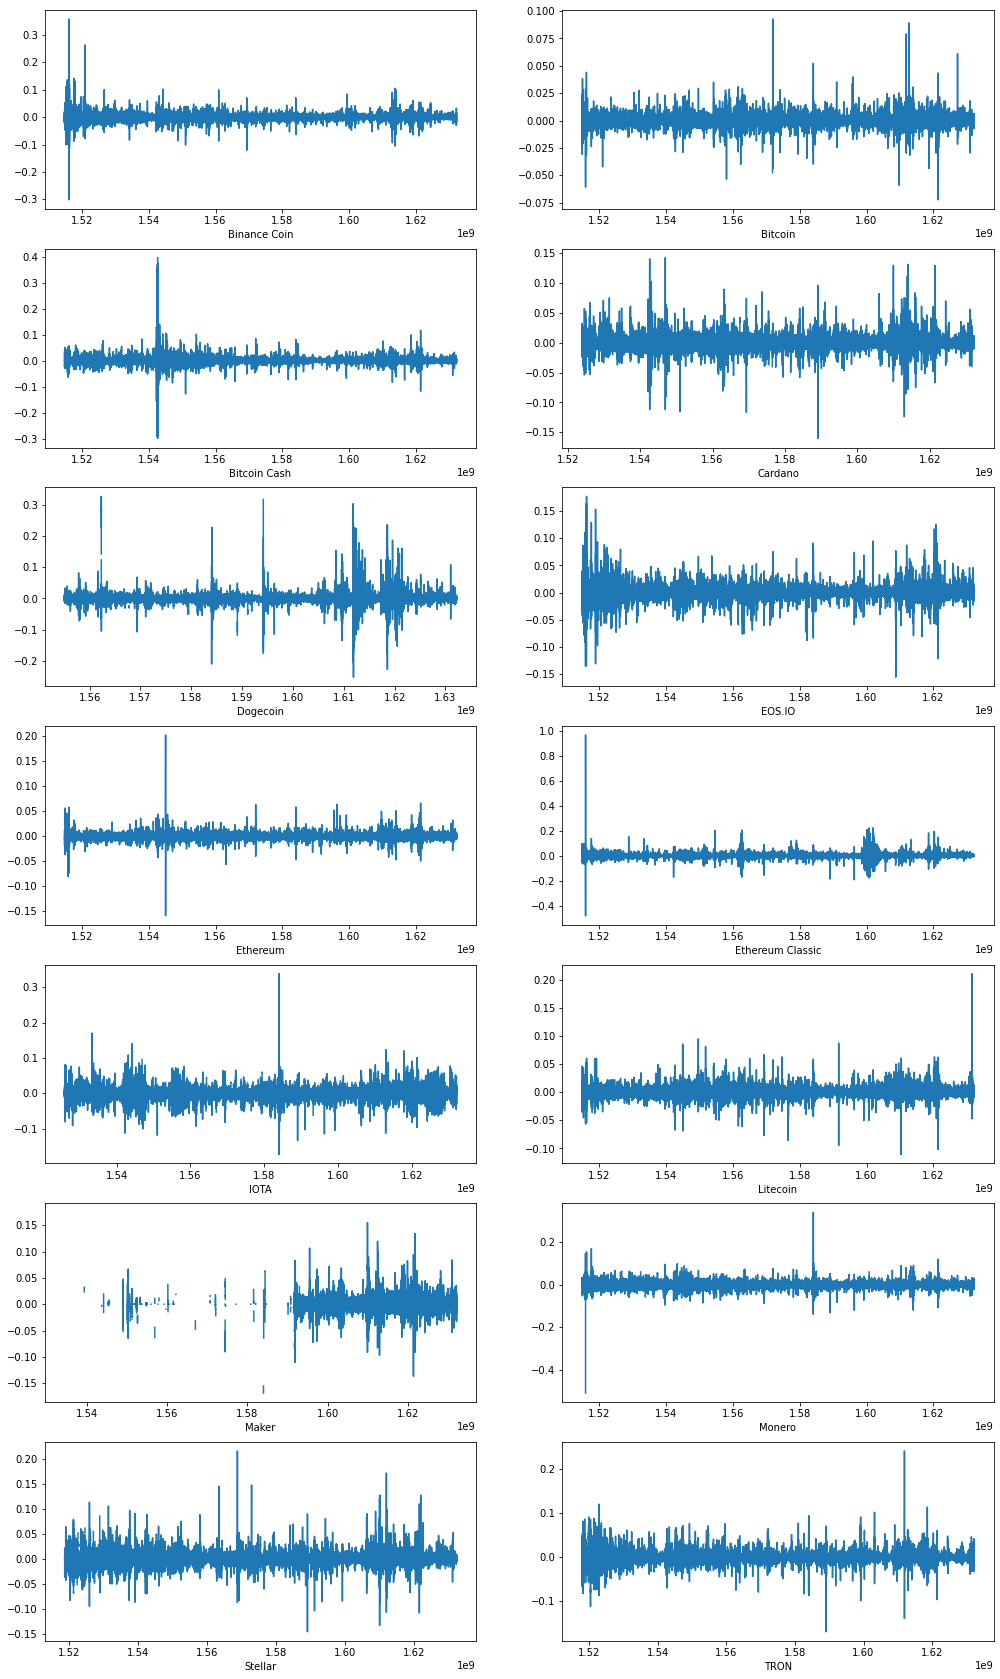

In [166]:
f,axes = plt.subplots(nrows=7,ncols=2,figsize =(17,30))
axc=[(i,j) for i in range(7) for j in range(2)]
for asset_id in asset_df_dict.keys():
    asset_name = asset_details[asset_details["Asset_ID"] == asset_id]['Asset_Name'].iloc[0]  
    axes[axc[asset_id][0],axc[asset_id][1]].plot(asset_df_dict[asset_id]['Target'])
    axes[axc[asset_id][0],axc[asset_id][1]].set(xlabel=asset_name)
    
plt.show()

##### correlation between assets

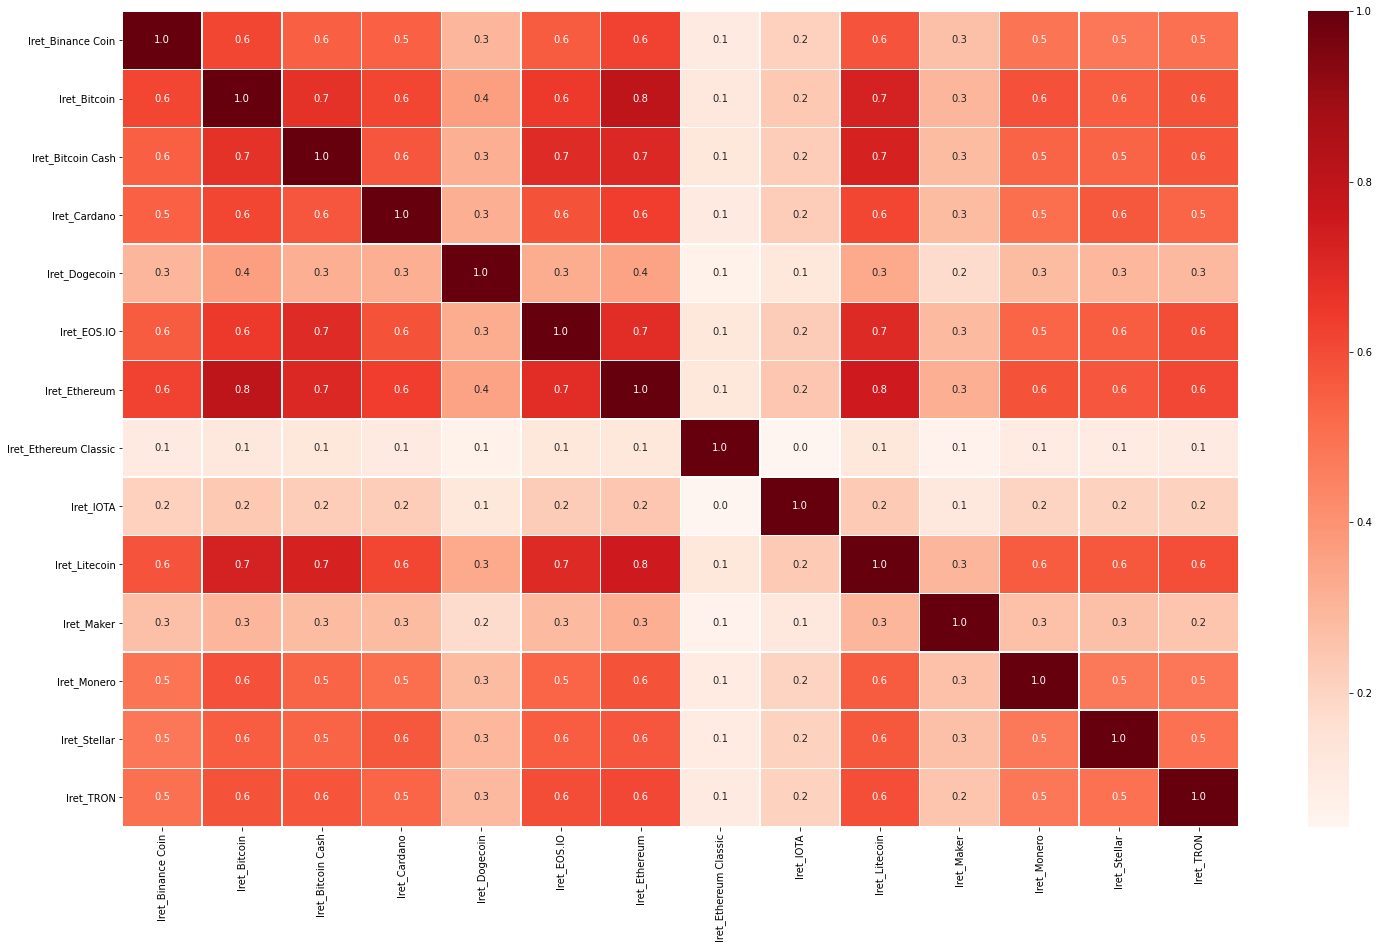

In [57]:
lret_assets=[]
for asset_id in asset_df_dict.keys():
    asset_name = asset_details[asset_details["Asset_ID"] == asset_id]['Asset_Name'].iloc[0]
    lret = log_return(asset_df_dict[asset_id].Close)[1:]
    lret.rename('lret_' + asset_name, inplace=True)
    lret_assets.append(lret)
    
lret_assets = pd.concat(lret_assets, axis=1)

f,ax = plt.subplots(figsize=(25, 15))
sns.heatmap(lret_assets.corr(), annot=True, linewidths=.5, fmt= '.1f',ax=ax,cmap="Reds")
plt.show()


## we will work on bitcoin

In [11]:
bitcoin_df = asset_df_dict[1]

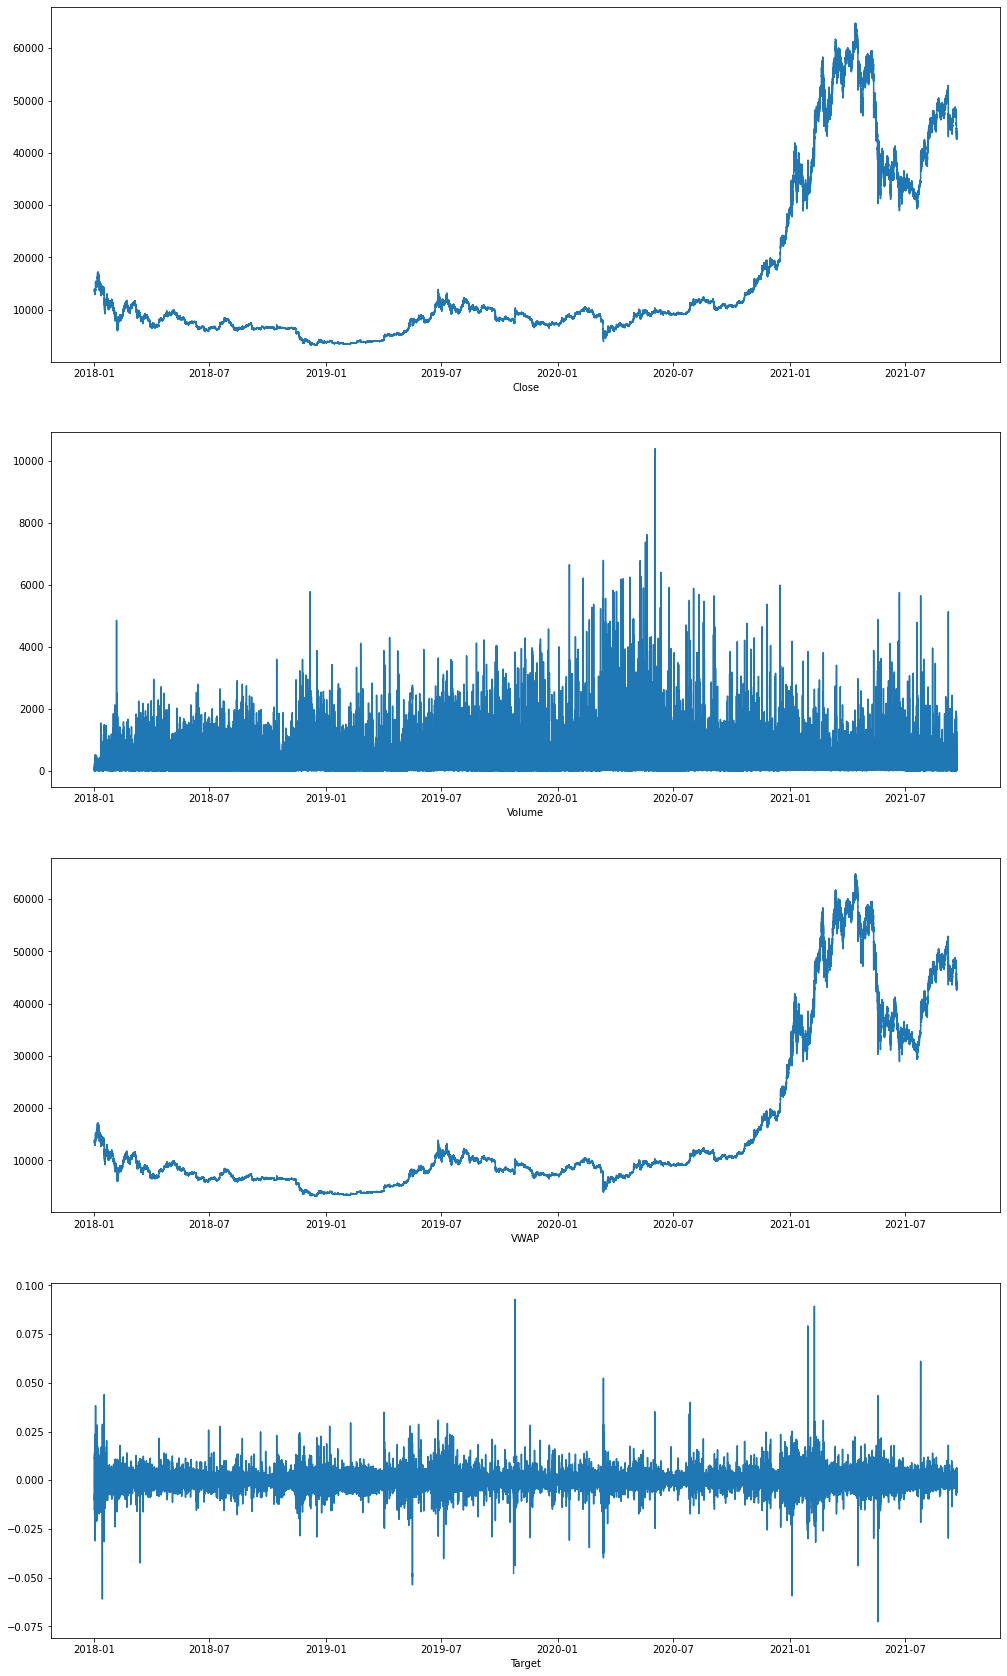

In [96]:
f,axes = plt.subplots(nrows=4,ncols=1,figsize =(17,30))
axc=[i for i in range(4) ]
for column_index in range(len(bitcoin_df.columns)):
    axes[axc[column_index]].plot(bitcoin_df[bitcoin_df.columns[column_index]])
    axes[axc[column_index]].set(xlabel=bitcoin_df.columns[column_index])
plt.show()

<AxesSubplot:>

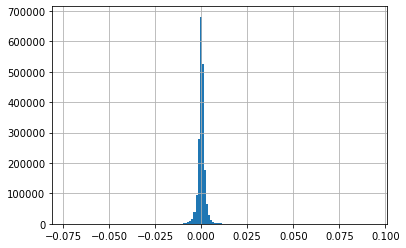

In [101]:
bitcoin_df['Target'].hist(bins = 150)

# feature engineering 

## Log returns

In order to analyze price changes for an asset we can deal with the price difference. However, different assets exhibit different price scales, so that the their returns are not readily comparable. We can solve this problem by computing the percentage change in price instead, also known as the return. This return coincides with the percentage change in our invested capital.

Returns are widely used in finance, however log returns are preferred for mathematical modelling of time series, as they are additive across time. Also, while regular returns cannot go below -100%, log returns are not bounded.

To compute the log return, we can simply take the logarithm of the ratio between two consecutive prices. The first row will have an empty return as the previous value is unknown, therefore the empty return data point will be dropped.

In [12]:
# define function to compute log returns
def log_return(series, periods=1):
    return np.log(series).diff(periods=periods)

In [13]:
def upper_shadow(df):
    return df['High'] - np.maximum(df['Close'], df['Open'])

In [14]:
def lower_shadow(df):
    return np.minimum(df['Close'], df['Open']) - df['Low']

In [15]:
def hlco_ratio(df): 
    return (df['High'] - df['Low'] + ep)  /(df['Close']-df['Open'] + ep)

In [16]:
# We use Plotly to create the plots https://plot.ly/python/
trace1 = go.Scatter(
    x = bitcoin_df.index,
    y = bitcoin_df['Open'].astype(float),
    mode = 'lines',
    name = 'Open'
)

trace2 = go.Scatter(
    x = bitcoin_df.index,
    y = bitcoin_df['Close'].astype(float),
    mode = 'lines',
    name = 'Close'
)


layout = dict(
    title='Historical Bitcoin Prices with the Slider ',
    xaxis=dict(
        rangeselector=dict(
            buttons=list([
                #change the count to desired amount of months.
                dict(count=1,
                     label='1m',
                     step='month',
                     stepmode='backward'),
                dict(count=6,
                     label='6m',
                     step='month',
                     stepmode='backward'),
                dict(count=12,
                     label='1y',
                     step='month',
                     stepmode='backward'),
                dict(count=36,
                     label='3y',
                     step='month',
                     stepmode='backward'),
                dict(step='all')
            ])
        ),
        rangeslider=dict(
            visible = True
        ),
        type='date'
    )
)

data = [trace1,trace2]
fig = dict(data=data, layout=layout)
iplot(fig, filename = "Time Series with Rangeslider")

KeyboardInterrupt: 

In [17]:
def create_features(df, label=None):
    """
    Creates time series features from datetime index
    """
    df['date'] = df.index
    df['hour'] = df['date'].dt.hour
    df['dayofweek'] = df['date'].dt.dayofweek
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day    
    df['Open'] = df['Open']
    df['Count'] = df['Count']
    df['High'] = df['High']
    df['Low'] = df['Low']
    df['Volume'] = df['Volume']
    df['VWAP'] = df['VWAP']
    df['upper_shadow'] = upper_shadow(df)
    df['lower_shadow'] = lower_shadow(df)
    
    df.replace([np.inf, -np.inf], np.nan, inplace=True)
    df.fillna(0 , inplace=True)
    
    X = df[['hour','dayofweek','quarter','month','year',
           'dayofyear','dayofmonth','Volume','VWAP']]
    if label:
        y = df[label]
        return X, y
    return X

### split date

In [18]:
split_date = '1-Jun-2021'

In [19]:
data_train = bitcoin_df.loc[bitcoin_df.index <= split_date].copy()
data_test = bitcoin_df.loc[bitcoin_df.index > split_date].copy()

In [ ]:
data_test.shape

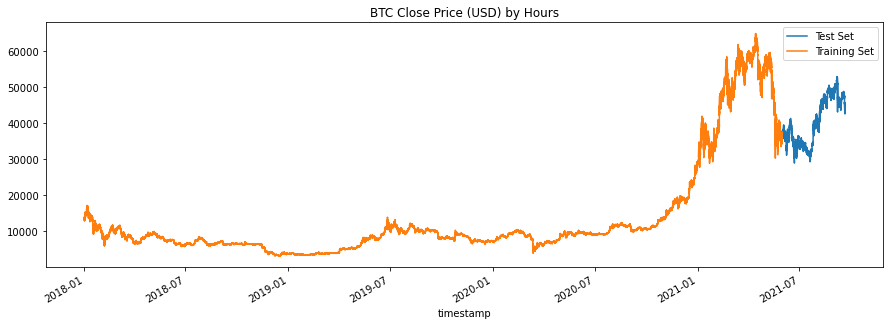

In [26]:
_ = data_test[['Close']] \
    .rename(columns={'Close': 'Test Set'}) \
    .join(data_train[['Close']].rename(columns={'Close': 'Training Set'}), how='outer') \
    .plot(figsize=(15,5), title='BTC Close Price (USD) by Hours', style='')

## LSTM

In [72]:
# LSTM

bitcoin_df = bitcoin_df[['Close']]
bitcoin_df['Close'].fillna(method='ffill', inplace=True)


data_train = bitcoin_df.loc[bitcoin_df.index <= split_date].copy()
data_test = bitcoin_df.loc[bitcoin_df.index > split_date].copy()


training_set = data_train.values.reshape(-1,1)

sc = MinMaxScaler()
training_set = sc.fit_transform(training_set)
X_train = training_set[0:len(training_set)-1]
y_train = training_set[1:len(training_set)]
X_train = X_train.reshape(-1,1,1)

test_set = data_test.values.reshape(-1,1)
test_set = sc.transform(test_set)
X_test = test_set[0:len(test_set)-1]
y_test = test_set[1:len(test_set)]
X_test = X_test.reshape(-1,1,1)


In [73]:
model = Sequential()
model.add(LSTM(128,activation="sigmoid",input_shape=(1,1)))
model.add(Dropout(0.2))
model.add(Dense(1))
model.summary()
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(X_train, y_train, epochs=50, batch_size=250, validation_data=(X_test, y_test), verbose=2)

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 128)               66560     
                                                                 
 dropout_4 (Dropout)         (None, 128)               0         
                                                                 
 dense_4 (Dense)             (None, 1)                 129       
                                                                 
Total params: 66,689
Trainable params: 66,689
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
7181/7181 - 74s - loss: 0.0069 - val_loss: 2.7458e-04 - 74s/epoch - 10ms/step
Epoch 2/50
7181/7181 - 59s - loss: 6.9487e-04 - val_loss: 1.1671e-04 - 59s/epoch - 8ms/step
Epoch 3/50
7181/7181 - 65s - loss: 3.6540e-04 - val_loss: 1.0510e-04 - 65s/epoch - 9ms/step
Epoch 4/50
7181/7181 - 57s - loss: 3.0758

In [85]:
data_test['Close_Prediction'] = np.zeros((X_test.shape[0]+1,1))
data_test['Close_Prediction'][1:] = sc.inverse_transform(model.predict(X_test)).reshape(-1)
data_all = pd.concat([data_test[1:], data_train], sort=False)

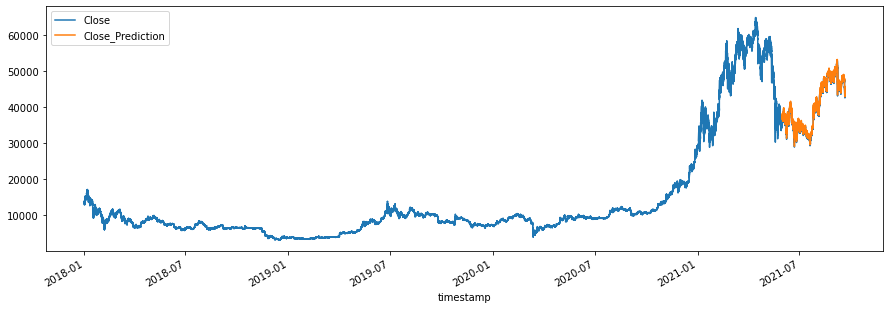

In [86]:
_ = data_all[['Close','Close_Prediction']].plot(figsize=(15, 5))

In [87]:
mean_squared_error(y_true=data_test['Close'],
                   y_pred=data_test['Close_Prediction'])

107273.68529458519

In [93]:
mean_absolute_error(y_true=data_test['Close'],
                   y_pred=data_test['Close_Prediction'])

310.7279933761216

In [88]:
print('Test score for LR baseline: BTC', f"{np.corrcoef(data_test['Close_Prediction'], data_test['Close'])[0,1]:.2f}")

Test score for LR baseline: BTC 1.00


In [94]:
final_data = data_all
final_data = final_data.rename(columns={'Close_Prediction': 'lstm'})

## XGBoost

In [97]:
import xgboost as xgb
from xgboost import plot_importance, plot_tree

data_train = bitcoin_df.loc[bitcoin_df.index <= split_date].copy()
data_test = bitcoin_df.loc[bitcoin_df.index > split_date].copy()

X_train, y_train = create_features(data_train, label='Close')
X_test, y_test = create_features(data_test, label='Close')

model =  xgb.XGBRegressor(objective ='reg:squarederror',min_child_weight=10, booster='gbtree', colsample_bytree = 0.3, learning_rate = 0.1,
                max_depth = 5, alpha = 10, n_estimators = 100)
model.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        early_stopping_rounds=50,
       verbose=False) 

XGBRegressor(alpha=10, base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.3, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.1, max_delta_step=0,
             max_depth=5, min_child_weight=10, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=4,
             num_parallel_tree=1, predictor='auto', random_state=0,
             reg_alpha=10, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [98]:
data_test['Close_Prediction'] = model.predict(X_test)
data_all = pd.concat([data_test, data_train], sort=False)

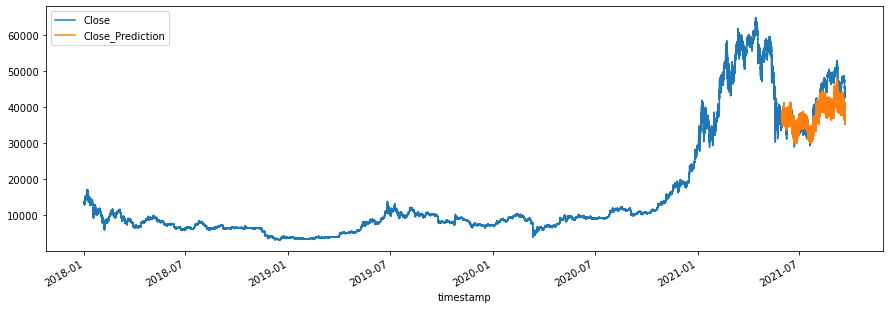

In [99]:
_ = data_all[['Close','Close_Prediction']].plot(figsize=(15, 5))

In [100]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
mean_squared_error(y_true=data_test['Close'],
                   y_pred=data_test['Close_Prediction'])

17641393.63457001

In [101]:
print('Test score for LR baseline: BTC', f"{np.corrcoef(data_test['Close_Prediction'], data_test['Close'])[0,1]:.2f}")

Test score for LR baseline: BTC 0.88


In [102]:
#adding to final data for comparision
final_data = pd.merge(final_data, data_all, sort=False)
final_data = final_data.rename(columns={'Close_Prediction': 'xgboost'})
#final_data = final_data[['Timestamp','Weighted_Price','lstm','xgboost']]

## KNN

In [20]:
from sklearn.neighbors import KNeighborsRegressor

data_train = bitcoin_df.loc[bitcoin_df.index <= split_date].copy()
data_test = bitcoin_df.loc[bitcoin_df.index > split_date].copy()

X_train, y_train = create_features(data_train, label='Close')
X_test, y_test = create_features(data_test, label='Close')

model = KNeighborsRegressor(n_neighbors=7)
model.fit(X_train, y_train)

KNeighborsRegressor(n_neighbors=7)

In [26]:
data_test['Close_Prediction'] = model.predict(X_test)
data_all = pd.concat([data_test, data_train], sort=False)


In [27]:
data_test.columns

Index(['timestamp', 'Asset_ID', 'Count', 'Open', 'High', 'Low', 'Close',
       'Volume', 'VWAP', 'Target', 'date', 'hour', 'dayofweek', 'quarter',
       'month', 'year', 'dayofyear', 'dayofmonth', 'upper_shadow',
       'lower_shadow', 'Close_Prediction'],
      dtype='object')

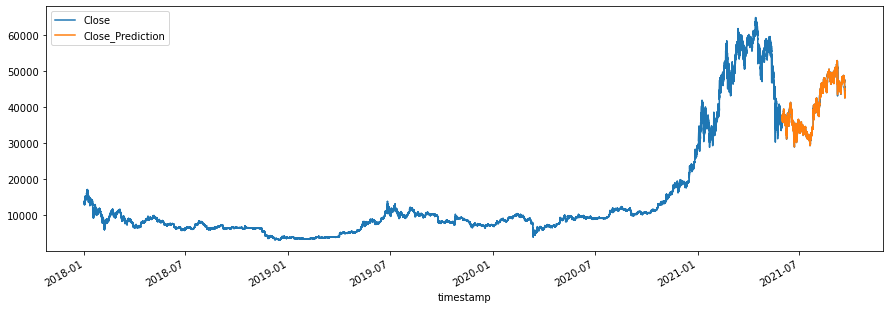

In [28]:
_ = data_all[['Close','Close_Prediction']].plot(figsize=(15, 5))

In [29]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
mean_squared_error(y_true=data_test['Close'],
                   y_pred=data_test['Close_Prediction'])

725.5616139421634

In [30]:
mean_absolute_error(y_true=data_test['Close'],
                   y_pred=data_test['Close_Prediction'])

18.37320395059731

In [31]:
print('Test score for LR baseline: BTC', f"{np.corrcoef(data_test['Close_Prediction'], data_test['Close'])[0,1]:.2f}")

Test score for LR baseline: BTC 1.00


In [32]:
from sklearn.ensemble import RandomForestRegressor

data_train = bitcoin_df.loc[bitcoin_df.index <= split_date].copy()
data_test = bitcoin_df.loc[bitcoin_df.index > split_date].copy()

X_train, y_train = create_features(data_train, label='Close')
X_test, y_test = create_features(data_test, label='Close')

ForestModel = RandomForestRegressor(min_samples_split=2,n_estimators=50).fit(X_train, y_train)

In [33]:
data_test['Close_Prediction'] = ForestModel.predict(X_test)
data_all = pd.concat([data_test, data_train], sort=False)

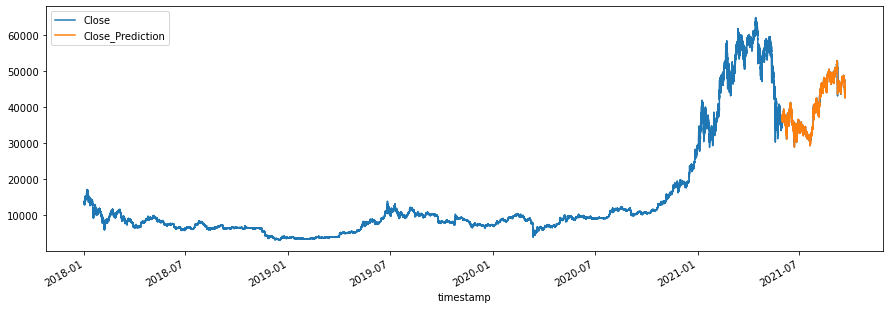

In [34]:
_ = data_all[['Close','Close_Prediction']].plot(figsize=(15, 5))

In [35]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
mean_squared_error(y_true=data_test['Close'],
                   y_pred=data_test['Close_Prediction'])

678.1650783126789

In [36]:
mean_absolute_error(y_true=data_test['Close'],
                   y_pred=data_test['Close_Prediction'])

17.14551937689544

In [37]:
print('Test score for LR baseline: BTC', f"{np.corrcoef(data_test['Close_Prediction'], data_test['Close'])[0,1]:.2f}")

Test score for LR baseline: BTC 1.00
